In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd '/content/gdrive/My Drive/DSF Project'

/content/gdrive/My Drive/DSF Project


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [0]:
df1 = pd.read_csv("costello_ace_2017-2018.csv", usecols=['Date','Item Number','Store #','Net Sales Units'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df2 = pd.read_csv("costello_ace_2015-2016.csv", usecols=['Date','Item Number','Store #','Net Sales Units'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df = df1.append(df2)

In [0]:
non_cmn_df = df[df['Item Number']!='9269862']
non_cmn_df = non_cmn_df[pd.notnull(non_cmn_df['Net Sales Units'])]
non_cmn_df = non_cmn_df[non_cmn_df['Net Sales Units']!='Net Sales Units']
non_cmn_df['Net Sales Units'] = pd.to_numeric(non_cmn_df['Net Sales Units'], errors='coerce')

In [0]:
le_store = preprocessing.LabelEncoder()
non_cmn_df['Store #'] = le_store.fit_transform(non_cmn_df['Store #'].values)
le_item_number = preprocessing.LabelEncoder()
non_cmn_df['Item Number'] = le_item_number.fit_transform(non_cmn_df['Item Number'].values)

In [0]:

clean_df = non_cmn_df[non_cmn_df['Net Sales Units']>0]
clean_df = clean_df[clean_df['Date']!='Date']
clean_df = clean_df[clean_df['Date']!='\x1a']
clean_df.Date = pd.to_datetime(clean_df.Date)

In [0]:
new_df = clean_df.groupby(['Date','Store #', 'Item Number'], as_index=False)['Net Sales Units'].sum()

In [0]:
index_df = new_df.set_index('Date')
index_df.index = pd.to_datetime(index_df.index)

In [0]:
items = pd.DataFrame(index_df.groupby(['Date','Item Number']).sum()['Net Sales Units']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

In [0]:
store_item = index_df.groupby(by=['Item Number','Store #'])['Net Sales Units'].sum().groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()

In [0]:
store_pct = store_item.transpose()

In [0]:
ns_per_day = 86400000000000
start_date = pd.to_datetime('January 1, 2017')

In [0]:
def add_feat(df, train_end_str):
    """Adds Features to DataFrame and Takes Averages for Dates Before train_end_str"""
    dataf = df
    dataf['Weekday'] = dataf.index.dayofweek
    dataf['Is_Mon'] = (dataf.index.dayofweek == 0) *1
    dataf['Is_Tue'] = (dataf.index.dayofweek == 1) *1
    dataf['Is_Wed'] = (dataf.index.dayofweek == 2) *1
    dataf['Is_Thu'] = (dataf.index.dayofweek == 3) *1
    dataf['Is_Fri'] = (dataf.index.dayofweek == 4) *1
    dataf['Is_Sat'] = (dataf.index.dayofweek == 5) *1
    dataf['Is_Sun'] = (dataf.index.dayofweek == 6) *1
    dataf['Is_wknd'] = dataf.index.dayofweek // 4 
    dataf['Day_Num'] = ((dataf.index - start_date)/ ns_per_day).astype(int)
    
    dataf['Month'] = dataf.index.month
    dataf['Day_of_Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 364
    dataf['Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) // 364 -1
    dataf['Day_of_Quarter'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 91
    dataf['Quarter'] = (((dataf.index - start_date)/ ns_per_day).astype(int) // 91) % 4
    dataf.reset_index(inplace=True)
    
    # Add prior year sales as additional feature
    prior_year_sales = dataf[['Date','Net Sales Units','Store #','Item Number']]
    prior_year_sales['Date'] += pd.Timedelta('364 days')
    prior_year_sales.columns =['Date','lag_12mo','Store #','Item Number']

    dataf = dataf.merge(prior_year_sales, on=['Date','Store #','Item Number'])
    
    # Add average by item by store by day of year as additional feature
    avg = dataf.loc[df['Date'] < pd.to_datetime(train_end_str), ['Day_of_Year','Net Sales Units','Store #','Item Number']].groupby(by=['Day_of_Year','Store #','Item Number']).mean().reset_index()
    avg.columns =['Day_of_Year','Store #','Item Number','DoY_Mean']
    
    dataf = dataf.merge(avg, on=['Day_of_Year','Store #','Item Number'])
    
    # Add average by day of week by quarter by item by store as additional feature
    avg = dataf.loc[df['Date'] < pd.to_datetime(train_end_str), ['Quarter','Weekday','Net Sales Units','Store #','Item Number']].groupby(by=['Quarter','Weekday','Store #','Item Number']).mean().reset_index()
    avg.columns =['Quarter','Weekday','Store #','Item Number','DoW_Mean']
    
    dataf = dataf.merge(avg, on=['Quarter','Weekday','Store #','Item Number'])
      
    # Remove first year of data as there is no prior year sales for them, then sort to match competition id's
    dataf = dataf[dataf['Year'] >=0].drop('Year', axis=1).sort_values(['Item Number','Store #','Date'])
    
    return dataf

In [0]:
index_df['Day'] = index_df.index.weekday_name
df_test = add_feat(index_df, 'September 1, 2018') # Takes average of training data

df_test.tail(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Store #,Item Number,Net Sales Units,Day,Weekday,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Is_wknd,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,lag_12mo,DoY_Mean,DoW_Mean
628990,2018-12-22,28,112232,6.0,Saturday,5,0,0,0,0,0,1,0,1,720,12,356,83,3,5.0,6.0,4.0
84099,2018-03-01,9,112241,1.0,Thursday,3,0,0,0,1,0,0,0,0,424,3,60,60,0,1.0,1.0,1.0
427834,2018-08-12,18,112261,1.0,Sunday,6,0,0,0,0,0,0,1,1,588,8,224,42,2,1.0,1.0,1.0
63602,2018-02-03,4,112265,1.0,Saturday,5,0,0,0,0,0,1,0,1,398,2,34,34,0,1.0,1.0,1.0
560112,2018-11-07,18,112290,1.0,Wednesday,2,0,0,1,0,0,0,0,0,675,11,311,38,3,1.0,1.0,1.0
625009,2018-12-06,18,112290,2.0,Thursday,3,0,0,0,1,0,0,0,0,704,12,340,67,3,1.0,2.0,2.0
618557,2018-12-03,4,112322,1.0,Monday,0,1,0,0,0,0,0,0,0,701,12,337,64,3,2.0,1.0,1.0
625644,2018-12-07,4,112322,1.0,Friday,4,0,0,0,0,1,0,0,1,705,12,341,68,3,1.0,1.0,1.0
627276,2018-12-08,4,112322,3.0,Saturday,5,0,0,0,0,0,1,0,1,706,12,342,69,3,5.0,3.0,3.0
629197,2018-12-09,4,112322,2.0,Sunday,6,0,0,0,0,0,0,1,1,707,12,343,70,3,3.0,2.0,2.0


In [0]:
x_train = df_test.loc[df_test['Date'] < pd.to_datetime('September 1, 2018')].drop(['Net Sales Units','Date','Day', 'Weekday'], axis=1)
y_train = df_test.loc[df_test['Date'] < pd.to_datetime('September 1, 2018'), 'Net Sales Units']

x_test_date = df_test.loc[df_test['Date'] >= pd.to_datetime('September 1, 2018')]['Date']

x_test = df_test.loc[df_test['Date'] >= pd.to_datetime('September 1, 2018')].drop(['Net Sales Units','Date','Day', 'Weekday'], axis=1).reset_index(drop=True)
y_test = df_test.loc[df_test['Date'] >= pd.to_datetime('September 1, 2018'), 'Net Sales Units'].reset_index(drop=True)

In [0]:
def xgboost(x_train, y_train, x_test):
    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    params = {'max_depth':3,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    num_rounds = 1500

    bst = xgb.train(params, dtrain, num_rounds)
    
    return pd.Series(bst.predict(dtest))

In [0]:
preds = xgboost(x_train, y_train, x_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
mean_squared_error(y_test, preds)

1.0547998824680844

# Graphs

In [0]:
stores = pd.DataFrame(new_df.groupby(['Date','Store #']).sum()['Net Sales Units']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)

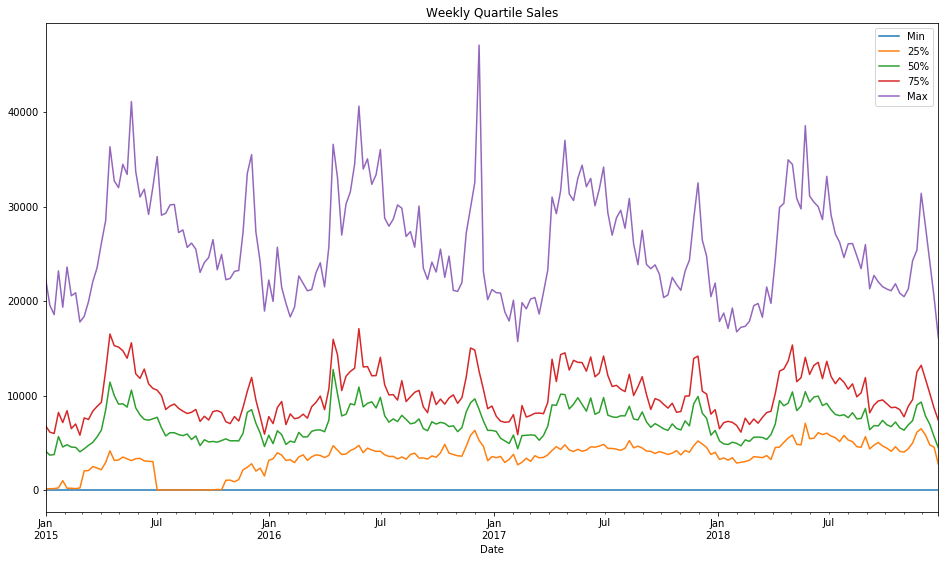

In [0]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

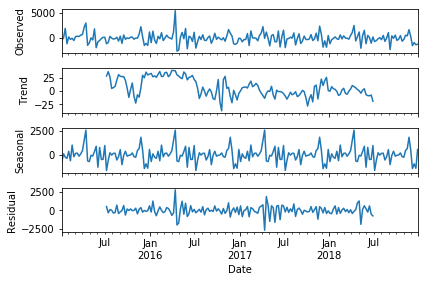

In [0]:
seasonal = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()